Set the Kernel as Python 3.5

In [ ]:
# Install the Custom Vision SDK
! pip install azure-cognitiveservices-vision-customvision

# Object Detection with the Custom Vision Service

In the world of computer vision, *object detection* is the next step from *image classification*. In image classification, your model classifies images based on their content. In object detection, the model determines the location of one or more objects in an image - typically predicting the coordinates of a *bounding box* that surrounds each object in the image.

More details at https://github.com/MicrosoftDocs/azure-docs/blob/master/articles/cognitive-services/Custom-Vision-Service/python-tutorial-od.md

In [1]:
import yaml
import os
from imutils import paths
from glob import glob
import xml.etree.ElementTree
import time
from PIL import Image, ImageOps
from azure.cognitiveservices.vision.customvision.training import training_api
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region

## Sign up for a Custom Vision service account
Now you're ready to use the Custom Vision service. If you haven't already done so, you'll need to sign up for an account. Then get your unique training and prediction keys so you can access it:
1. Go to https://customvision.ai/ and sign in using your Microsoft account to  log into your custom vision service (or create one, agreeing to the conditions - you don't need to create an Azure subscription for this exercise).
2. Click the *Settings* (&#9881;) icon at the top right to view your *training key* and *prediction key*. Then assign these to the variables below and run the cell:

In [2]:
"""
Create a file config.yml in the python folder containing your microsoft text translator key

credentials:
    training_key:                   # your customvision.ai training key 
    prediction_key:                 # your customvision.ai prediction key 
"""

#with open(os.path.join(os.path.dirname(os.path.abspath(__file__)),"config.yml"), 'r') as ymlfile:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

credentials = cfg['credentials']
training_key = credentials['training_key'] # your customvision.ai training key 
prediction_key = credentials['prediction_key'] # your customvision.ai prediction key 

In [3]:
projectName="birddetection"
dataFolderName = 'data'
imageFolderName = projectName+'_images'

project_id="" # leave this blank unless you are working against an existing project in customvision.ai
iteration_id = "" # leave this blank unless you are working against an existing training set in customvision.ai

img_dir = os.path.join(dataFolderName,imageFolderName)

In [4]:
imagePaths = list(paths.list_images(img_dir))
categories = [item[len(img_dir)+1:] for item in sorted(glob(os.path.join(img_dir,"*")))]

print('There are %d total categories.' % len(categories))
print(categories)

There are 9 total categories.
['cockatoo', 'fantail', 'kaka', 'kakapo', 'kea', 'kiwi', 'kokako', 'morepork', 'tui']


In [5]:
# https://docs.microsoft.com/en-us/python/api/azure.cognitiveservices.vision.customvision?view=azure-python

trainer = training_api.TrainingApi(training_key)

domains = trainer.get_domains()
domain_id = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection").id

# Create a new project
if (project_id==""):
    project = trainer.create_project(projectName, domain_id=domain_id)
    project_id = project.id
    print("Created Project - "+project.name+" : "+project.id)

Created Project - birddetection : 2587226e-914e-47d0-ae74-f9c5dfc82714


In [6]:
def createSetTag(label):
    if (tags[label] is None):
        tags[label] = trainer.create_tag(project_id, label)

In [7]:
tags = dict((l,None) for l in categories)
for i in range(len(categories)):
    createSetTag(str(categories[i]))

### Image Annotation

Manually annotated object locations are required to train and evaluate an object detector. One excellent UI to help drawing bounding boxes is [LabelImg](https://tzutalin.github.io/labelImg) which can be installed using [windows_v1.6.0.zip](https://www.dropbox.com/s/tq7zfrcwl44vxan/windows_v1.6.0.zip?dl=1). LabelImg writes an xml-file per image in Pascal-VOC format, which can be used across the [Azure Machine Learning Packages for Computer Vision](https://docs.microsoft.com/en-us/azure/machine-learning/service/reference-python-package-overview?branch=release-build-2018-aml). For more information see the [Tensorflow object detection website](https://github.com/tensorflow/models/tree/master/research/object_detection).

Alternatively you can use [VoTT](https://github.com/Microsoft/VoTT) to tag your images.

The code below assumes that you have a .xml file for each .jpg image saved in the same directory.

In [32]:
from matplotlib import image as mpimg
#tagged_images_with_regions = []

imagePaths = list(paths.list_images(img_dir))
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    
    tagname = imagePath.split(os.path.sep)[-2]
    img = mpimg.imread(imagePath)
    img_h, img_w, img_ch = img.shape

    if (img_ch==4) : # image has 4 channels the alpha channel needs to be stripped and turned into 3 channel RGB
        im = Image.open(imagePath)
        rgb_im = im.convert('RGB')
        rgb_im.save(imagePath)
        print(imagePath)

    e = xml.etree.ElementTree.parse(imagePath.replace('.jpg','.xml')).getroot()
    if (int(e.find('size').find('width').text)==img_w) and (int(e.find('size').find('height').text)==img_h):
        for atype in e.findall('object'):
            if (tagname == atype.find('name').text): 
                l = int(atype.find('bndbox').find('xmin').text) / img_w
                r = int(atype.find('bndbox').find('xmax').text) / img_w
                t = int(atype.find('bndbox').find('ymin').text) / img_h
                b = int(atype.find('bndbox').find('ymax').text) / img_h

                w = r-l
                h = b-t

                regions = [Region(tag_id=tags[tagname].id, left=l,top=t,width=w,height=h)]
                ifce = []
                with open(imagePath, mode="rb") as image_contents:
                    #tagged_images_with_regions.append(ImageFileCreateEntry(name=imagePath, contents=image_contents.read(), regions=regions))
                    ifce.append(ImageFileCreateEntry(name=imagePath, contents=image_contents.read(), regions=regions))

                trainer.create_images_from_files(project.id, images=ifce)

    # show an update every 50 images
    if i > 0 and i % 50 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        

[INFO] processed 50/1014
[INFO] processed 100/1014
[INFO] processed 150/1014
[INFO] processed 200/1014
[INFO] processed 250/1014
[INFO] processed 300/1014
[INFO] processed 350/1014
[INFO] processed 400/1014
[INFO] processed 450/1014
[INFO] processed 500/1014
[INFO] processed 550/1014
[INFO] processed 600/1014
[INFO] processed 650/1014
[INFO] processed 700/1014
[INFO] processed 750/1014
[INFO] processed 800/1014
[INFO] processed 850/1014
[INFO] processed 900/1014
[INFO] processed 950/1014
[INFO] processed 1000/1014


In [33]:
print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# The iteration is now trained. Make it the default project endpoint
trainer.update_iteration(project.id, iteration.id, is_default=True)
print ("Done!")

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training


	kaka: 37.58%
	kakapo: 36.97%
	kea: 80.50%


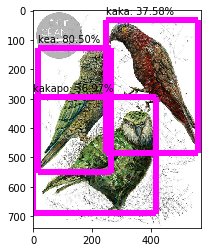

In [35]:
from azure.cognitiveservices.vision.customvision.prediction import prediction_endpoint
from azure.cognitiveservices.vision.customvision.prediction.prediction_endpoint import models
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
%matplotlib inline

# Now there is a trained endpoint that can be used to make a prediction
test_img_file = os.path.join(dataFolderName,imageFolderName,"keakakakakapo.jpg") #replace this with a .jpg that you wish to test
test_img = Image.open(test_img_file)
test_img_h, test_img_w, test_img_ch = np.array(test_img).shape
    
predictor = prediction_endpoint.PredictionEndpoint(prediction_key)

# Open the sample image and get back the prediction results.
with open(test_img_file, mode="rb") as test_data:
    results = predictor.predict_image(project.id, test_data, iteration.id)
    
# Display the results.
draw = ImageDraw.Draw(test_img)

for prediction in results.predictions:
    if (prediction.probability*100) > 30: # only show predictions that are better than 30%
        print ("\t" + prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100))
        
        
        left = prediction.bounding_box.left * test_img_w 
        top = prediction.bounding_box.top * test_img_h 
        height = prediction.bounding_box.height * test_img_h
        width =  prediction.bounding_box.width * test_img_w
        points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
        draw.line(points, fill='magenta', width=20)
        plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top-20))
        
plt.imshow(test_img)